In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [ ]:
raw_train_values = pd.read_csv('train_values.csv')
raw_train_labels = pd.read_csv('train_labels.csv')

In [ ]:
len(raw_train_values)

260601

In [ ]:
raw_train_values.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# train test split
trainX, testX, trainY, testY = train_test_split(raw_train_values, raw_train_labels['damage_grade'], test_size=0.25) 

In [ ]:
# normalizes features so they range from 0 to 1
def min_max_columns(df, cols):
    
    df_subset = df[cols]
    
    # switch up scaling to see differences
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    df_scaled = pd.DataFrame(min_max_scaler.fit_transform(df_subset))

    namedict = {}
    for i in range(len(cols)):
        namedict[i] = cols[i]

    df_scaled.rename(columns=namedict, inplace=True)
    df_original = df.drop(columns=cols).reset_index()

    return pd.concat([df_scaled, df_original], axis=1)

def robust_columns(df, cols):
    
    df_subset = df[cols]
    
    # switch up scaling to see differences
    min_max_scaler = preprocessing.RobustScaler()
    df_scaled = pd.DataFrame(min_max_scaler.fit_transform(df_subset))

    namedict = {}
    for i in range(len(cols)):
        namedict[i] = cols[i]

    df_scaled.rename(columns=namedict, inplace=True)
    df_original = df.drop(columns=cols).reset_index()

    return pd.concat([df_scaled, df_original], axis=1)

# convert percentages to decimal from 0 to 1
def percent_to_decimal(df, cols):

    for name in cols:
        df[name] = df[name] / 100

    return df

# converts categorical features to binary features
def onehot_encoding(df, cols):

    for col_name in cols:
        df = pd.get_dummies(df, columns=[col_name])

    return df


In [ ]:
def processing(df):
    cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
    norm_data = min_max_columns(df, cols)

    cols = ['count_floors_pre_eq', 'age']
    norm_data = robust_columns(norm_data, cols)

    percent_data = percent_to_decimal(norm_data, ['area_percentage','height_percentage'])

    categorical = ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 
                  'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']
    final = onehot_encoding(percent_data, categorical)

    return final

# Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
trainX = processing(trainX)
testX = processing(testX)

In [ ]:
dtree = DecisionTreeClassifier(max_depth=25, max_features='auto')
dtree.fit(trainX, trainY)
preds = dtree.predict(trainX)

In [ ]:
dtree.score(testX, testY)

0.6179030252797347

# Random Forest Classifier
## Hyperparameter Tuning via RandomizedSearch

In [ ]:
features = ['foundation_type_w',
 'count_families',
 'other_floor_type_q',
 'ground_floor_type_f',
 'roof_type_x',
 'has_superstructure_timber',
 'has_superstructure_cement_mortar_brick',
 'foundation_type_i',
 'count_floors_pre_eq',
 'ground_floor_type_v',
 'has_superstructure_mud_mortar_stone',
 'foundation_type_r',
 'height_percentage',
 'area_percentage',
 'age',
 'geo_level_3_id',
 'geo_level_2_id',
 'geo_level_1_id']

In [ ]:
trainX = trainX[features]
testX = testX[features]

In [ ]:
Xtrain, Xval, Ytrain, Yval = train_test_split(trainX, trainY, test_size=0.40) 

In [ ]:
n_estimators = [i for i in range(180,230,8)]
max_features = ['auto', 'sqrt']
max_depth = [i for i in range(40,70,5)]
min_samples_leaf = [i for i in range(2,12,3)]
bootstrap = [True, False]

In [ ]:
params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf, 
               'max_depth': max_depth,
               'bootstrap': bootstrap}

In [ ]:
rf_clf = RandomForestClassifier(n_jobs=2)

rf_RandomGrid = RandomizedSearchCV(estimator=rf_clf, param_distributions=params)

In [ ]:
rf_RandomGrid.fit(Xval, Yval)

/Users/vladiatrinh/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/vladiatrinh/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/vladiatrinh/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=2),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [40, 45, 50, 55, 60, 65],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 5, 8, 11],
                                        'n_estimators': [180, 188, 196, 204,
                                                         212, 220, 228]})

In [ ]:
rf_RandomGrid.best_params_

{'n_estimators': 228,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 65,
 'bootstrap': True}

In [ ]:
print (f'Train Accuracy - : {rf_RandomGrid.score(Xval,Yval):.3f}')
print (f'Test Accuracy - : {rf_RandomGrid.score(testX,testY):.3f}')

Train Accuracy - : 0.892
Test Accuracy - : 0.716


In [ ]:
tree = RandomForestClassifier(n_estimators=228, 
                              max_depth=65, 
                              min_samples_leaf=2,
                              max_features='sqrt', 
                              bootstrap=True).fit(Xtrain, Ytrain)

In [ ]:
my_tree = RandomForestClassifier(n_estimators=200, 
                              max_depth=50, 
                              min_samples_leaf=3,
                              max_features='sqrt', 
                              bootstrap=False).fit(Xtrain, Ytrain)

print(my_tree.score(Xtrain, Ytrain))
print(my_tree.score(testX, testY))

0.889843949859299
0.7205108133413148


<BarContainer object of 18 artists>

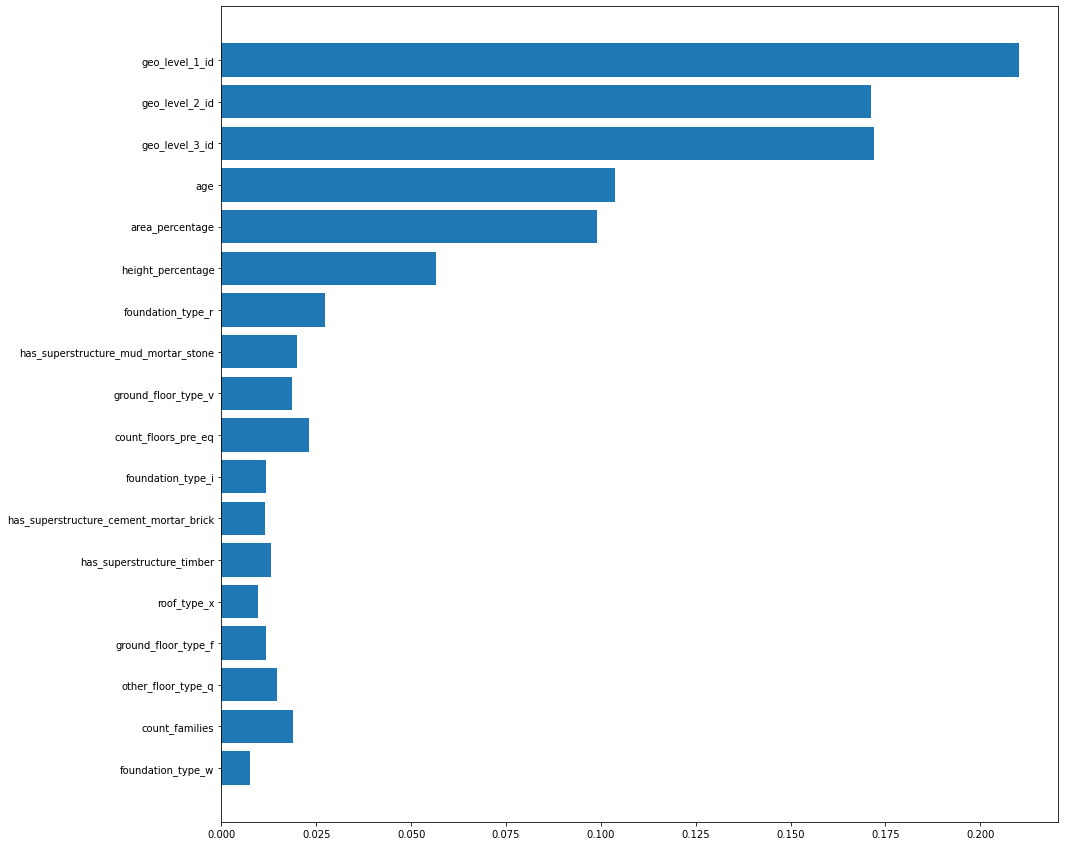

In [ ]:
plt.figure(figsize=(15,15))
plt.barh(Xtrain.columns, tree.feature_importances_)


In [ ]:
tree.score(Xtrain, Ytrain)

0.8874136607828089

In [ ]:
testX = testX[features]
tree.score(testX, testY)

0.7194517351997667

# XGBoost

XGBClassifier

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
#from sklearn.grid_search import GridSearchCV

#from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, KFold

In [ ]:
xgbc = XGBClassifier()
xgbc.fit(trainX, trainY)

XGBClassifier(objective='multi:softprob')

In [ ]:
scores = cross_val_score(xgbc, trainX, trainY, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.67


In [ ]:
from sklearn.metrics import confusion_matrix
predY = xgbc.predict(testX)
cm = confusion_matrix(testY,predY) 
print(cm)

[[ 2185  4043    68]
 [ 1197 32289  3373]
 [   91 12696  9209]]


In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy on test set = {}".format(accuracy_score(testY, predY)))

Accuracy on test set = 0.6704885573513837


In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbc, trainX, trainY, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.67


Hyperparameter Tuning

In [ ]:
model_xgb = XGBClassifier(objective='multi:softmax', num_class=3, max_depth=2, n_estimators=10)


Accuracy: 62.71% (0.10%)


In [ ]:
# K-Fold Cross Validation
from sklearn.model_selection impoKFold

kfold = KFold(n_splits=5)
results = cross_val_score(model_xgb, trainX, trainY, cv=kfold)

print("Avg. accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
model_xgb.fit(trainX, trainY)

XGBClassifier(max_depth=2, n_estimators=10, num_class=3,
              objective='multi:softprob')

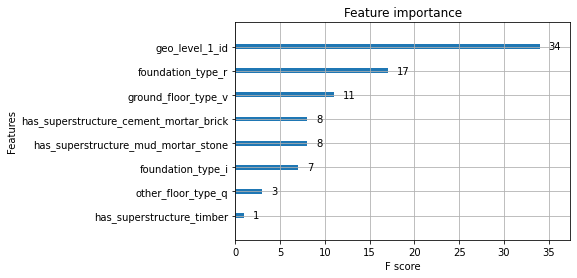

In [ ]:
import xgboost

# Plot the top 8 features
xgboost.plot_importance(model_xgb, max_num_features=8)
plt.show()

In [ ]:
predY = model_xgb.predict(testX)

confusion_matrix(testY, predY)

array([[  463,  5881,    15],
       [  367, 35902,   934],
       [  108, 16724,  4757]])

In [ ]:
from sklearn.model_selection import GridSearchCV
#multi:softmax – multiclass classification using the softmax objective, returns predicted class (not probabilities)
#num_class = parameter defining the number of unique classes

params = {
     "max_depth"        : [ 3, 6, 9],
     "learning_rate"    : [ 0.1, 0.4, 0.8],
     "n_estimators"     : [ 100, 500, 1000],
     "colsample_bytree" : [ 0.2, 0.5, 0.8 ],
     "gamma"            : [ 0.0, 0.1, 0.3, 0.6 ],  #The higher Gamma is, the higher the regularization
     "min_child_weight" : [ 1, 3, 5, 7 ],    
     "num_class"        : [3]
     }

xgb_ht = XGBClassifier(objective="multi:softmax")

grid = GridSearchCV(xgb_ht,
                    params,
                    n_jobs = -1,
                    verbose=1,
                    cv=3)

grid.fit(trainX, trainY)

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


In [ ]:
print("Best parameters:", grid.best_params_)